In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [103]:
visitationFile = "F:\\Azycon\\Visitation.xlsx"
meteorologyFile = "F:\\Azycon\\Meteorology.xlsx"

In [114]:
visitationData = pd.read_excel(visitationFile)
meterologyData = pd.read_excel(meteorologyFile)
visitationData.drop(columns=["Mt. Baw Baw", "Mt. Stirling", "Selwyn", "Charlotte Pass"], inplace=True)
meterologyData = meterologyData[~(meterologyData['Bureau of Meteorology station number'].isin([72161, 85291]))]

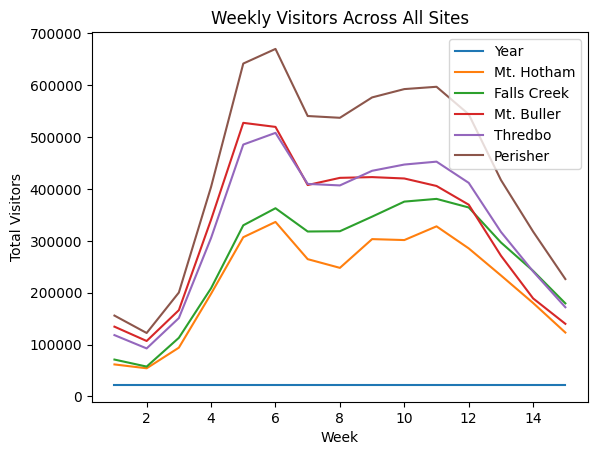

In [105]:

# Adding total visitor of each week per sites.
weeklyVisitationPerSite = visitationData.groupby('Week').sum().reset_index()
x = weeklyVisitationPerSite['Week']
for site in weeklyVisitationPerSite.columns[1:]:
    y = weeklyVisitationPerSite[site]
    plt.plot(x, y, label=site)

plt.xlabel('Week')
plt.ylabel('Total Visitors')
plt.title('Weekly Visitors Across All Sites')
plt.legend()
plt.show()

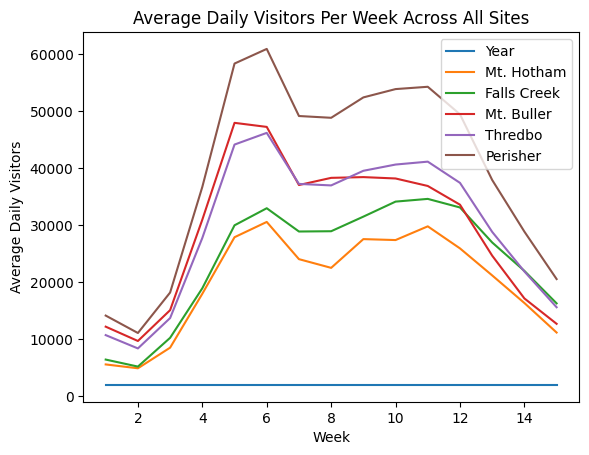

In [106]:
#Calculate the average of daily visitor per week per site
weeklyAvgVisitationPerSite = visitationData.groupby('Week').mean().reset_index()
x = weeklyAvgVisitationPerSite['Week']
for site in weeklyAvgVisitationPerSite.columns[1:]:
    y = weeklyAvgVisitationPerSite[site]
    plt.plot(x, y, label=site)
plt.xlabel('Week')
plt.ylabel('Average Daily Visitors')
plt.title('Average Daily Visitors Per Week Across All Sites')
plt.legend()
plt.show()


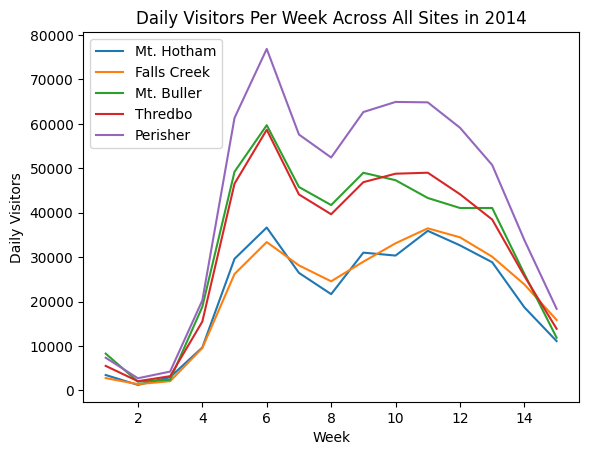

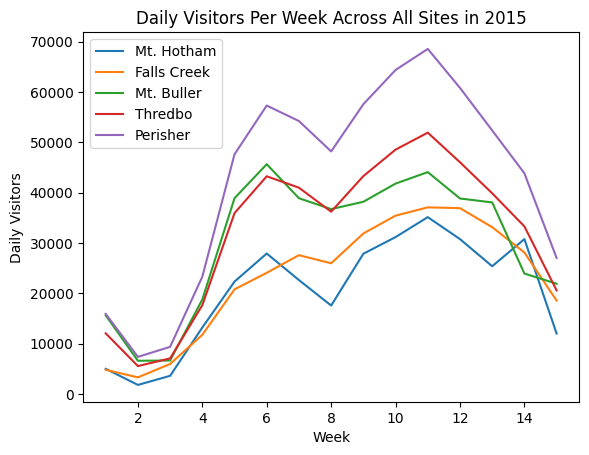

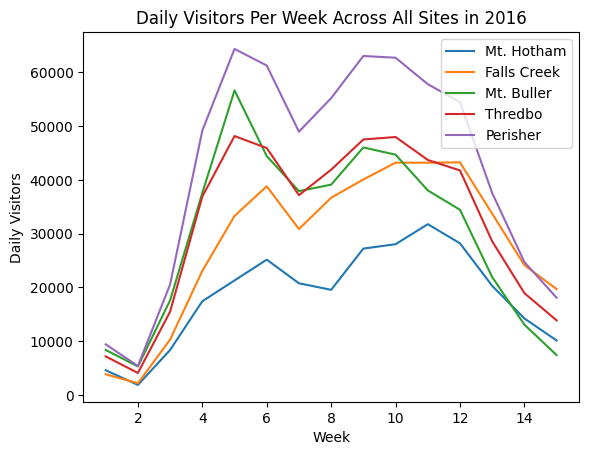

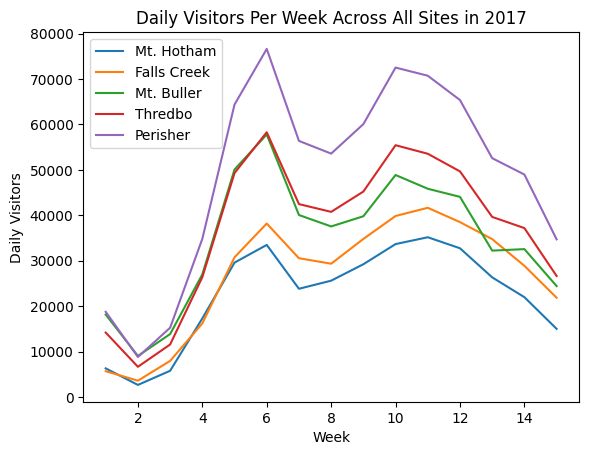

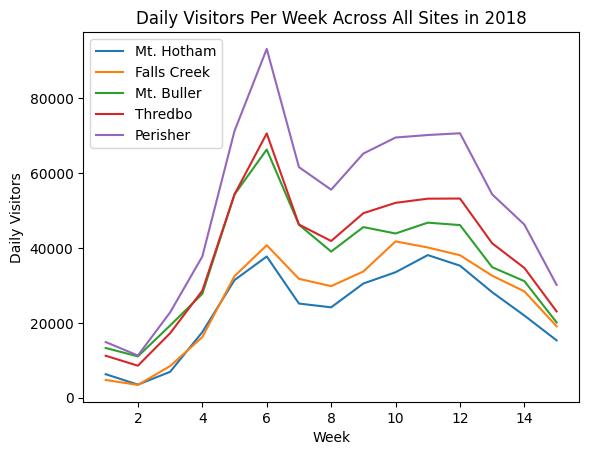

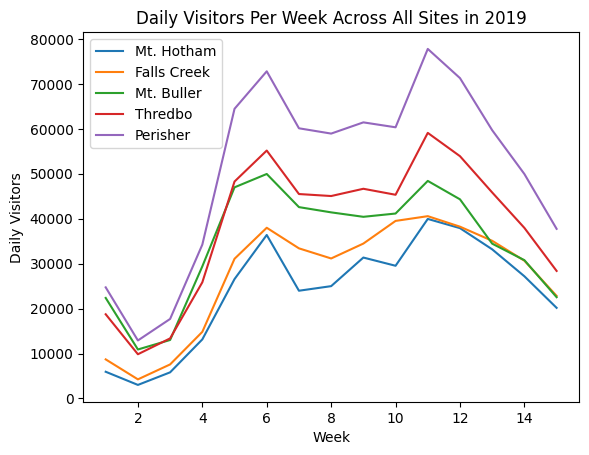

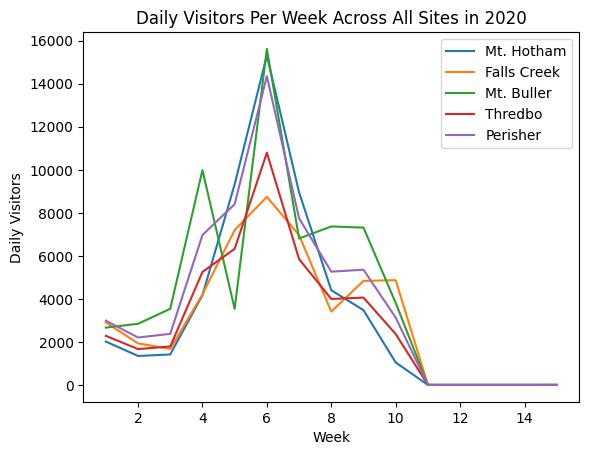

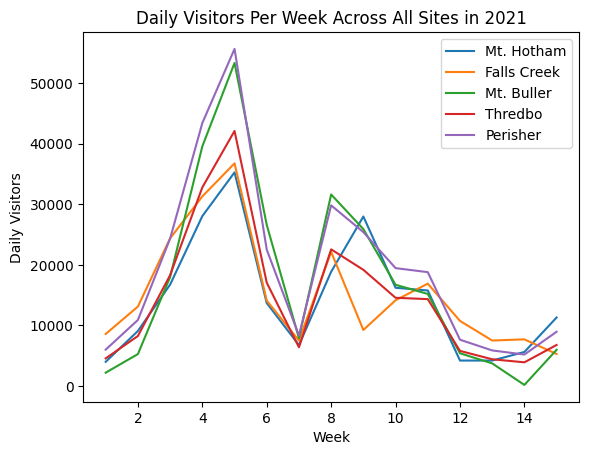

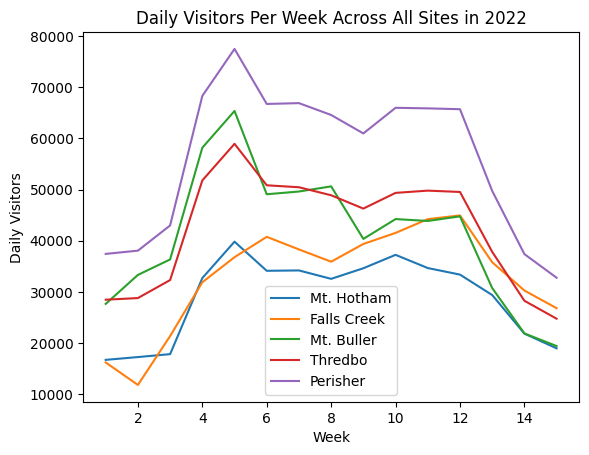

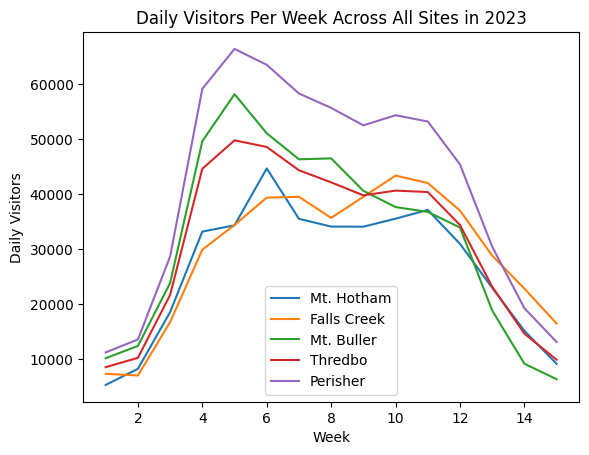

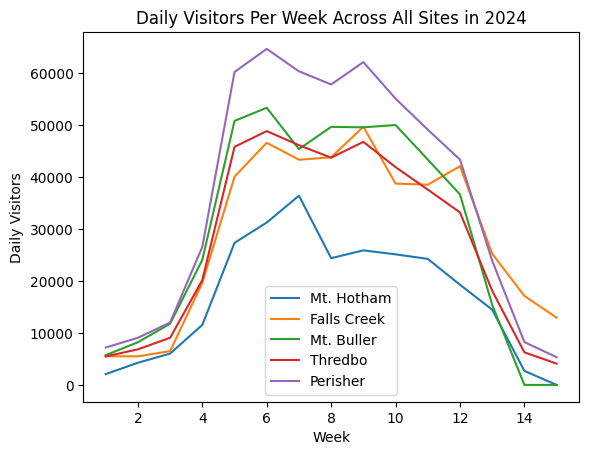

In [107]:
for year in visitationData['Year'].unique():
    yearlyData = visitationData[visitationData['Year'] == year]
    for site in yearlyData.columns[2:]:
        plt.plot(yearlyData['Week'], yearlyData[site], label=site)
    plt.xlabel('Week')
    plt.ylabel('Daily Visitors')
    plt.title(f'Daily Visitors Per Week Across All Sites in {year}')
    plt.legend()
    plt.show()

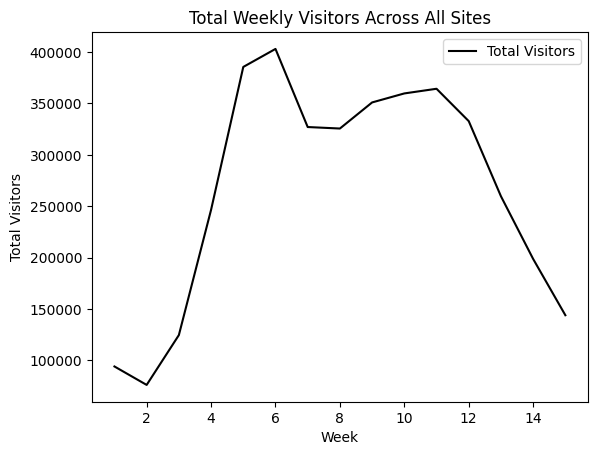

In [108]:
weeklyVisitationPerSite['TotalVisitors'] = weeklyVisitationPerSite.iloc[:, 1:].mean(axis=1)
plt.plot(weeklyVisitationPerSite['Week'], weeklyVisitationPerSite['TotalVisitors'], label='Total Visitors', color='black')
plt.xlabel('Week')
plt.ylabel('Total Visitors')
plt.title('Total Weekly Visitors Across All Sites')
plt.legend()
plt.show()

# Meterology Data Clean Ups, and analysis

In [109]:
# Clean the datas by:
# For each years, remove all days before 9-Jun and After 15-Sep
mask = (
    ((meterologyData['Month'] == 6) & (meterologyData['Day'] >= 9)) |
    ((meterologyData['Month'] > 6) & (meterologyData['Month'] < 9)) |
    ((meterologyData['Month'] == 9) & (meterologyData['Day'] <= 21))
)

filteredMeterologyData = meterologyData[mask].copy()

# Removing all years before 2014 and after 2024
filteredMeterologyData = filteredMeterologyData[(filteredMeterologyData['Year'] >= 2014) & (filteredMeterologyData['Year'] <= 2024)]

# Removing all Maximum temperature (Degree C) > 8.0C and Minimum temperature (Degree C) > 0.0C
filteredMeterologyData = filteredMeterologyData[
    (filteredMeterologyData['Maximum temperature (Degree C)'] <= 6.0) & 
    (filteredMeterologyData['Minimum temperature (Degree C)'] <= 0.0)
]

In [110]:
# For each weather forcast station (ski resort), for each years, group the dates together into weeks.
# That is from 9-Jun to 15-Jun is week 1, 16-Jun to 22-Jun is week 2, ..., 15-Sep to 21-Sep is week 15.
# The grouping is perform by totalling the weather data for each day of the week,
# And that week weather data will be the average of the totalling.

# Build a Date column
filteredMeterologyData['Date'] = pd.to_datetime(dict(
    year=filteredMeterologyData['Year'],
    month=filteredMeterologyData['Month'],
    day=filteredMeterologyData['Day']
))

# Compute week number relative to June 9 of that year
season_start = pd.to_datetime(dict(
    year=filteredMeterologyData['Year'],
    month=[6]*len(filteredMeterologyData),
    day=[9]*len(filteredMeterologyData)
))
filteredMeterologyData['Week'] = ((filteredMeterologyData['Date'] - season_start).dt.days // 7 + 1).clip(upper=15)

# Choose numeric weather columns to aggregate (exclude date parts)
exclude_cols = {'Year','Month','Day','Week', 'Bureau of Meteorology station number', 'Date'}
value_cols = [c for c in filteredMeterologyData.select_dtypes(include='number').columns if c not in exclude_cols]
print(value_cols)

['Maximum temperature (Degree C)', 'Minimum temperature (Degree C)', 'Rainfall amount (millimetres)']


In [111]:
# Weekly aggregation per Station & Year
weeklyWeather = (filteredMeterologyData
                 .groupby(['Bureau of Meteorology station number','Year','Week'], 
                          as_index=False)[value_cols]
                 .mean())   # use .sum() if you really want totals

weeklyWeather = weeklyWeather[weeklyWeather["Year"].between(2014, 2025)]

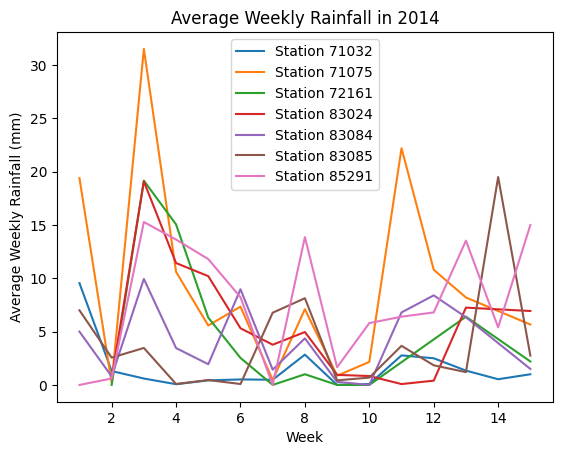

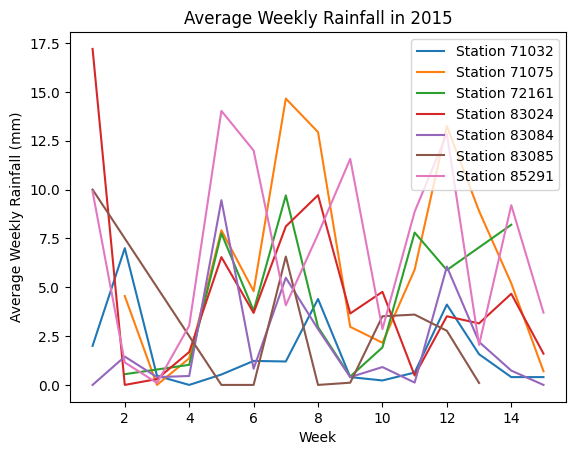

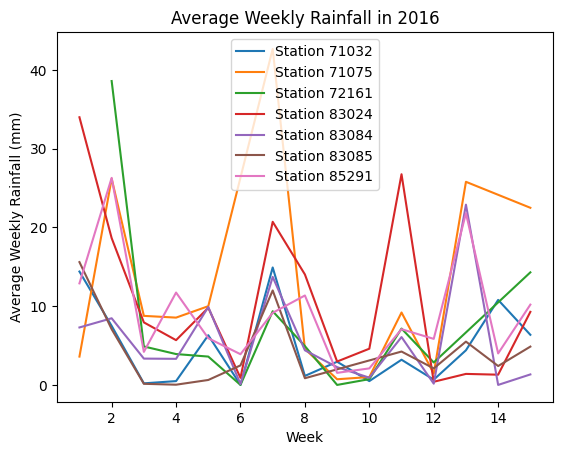

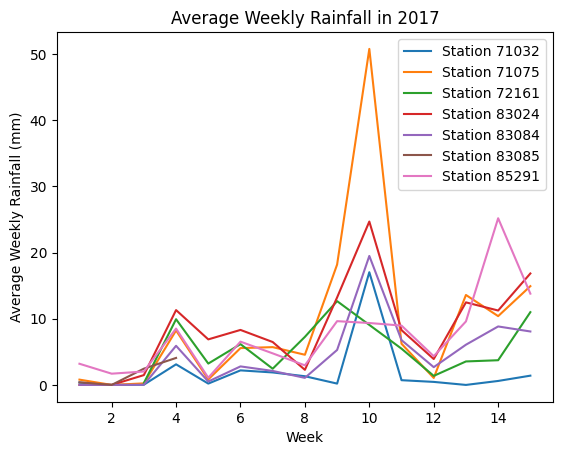

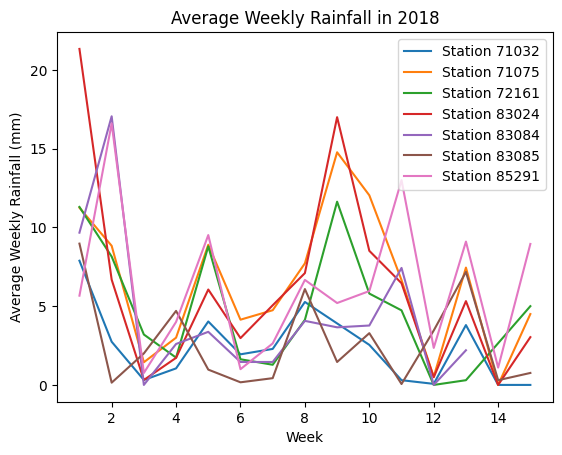

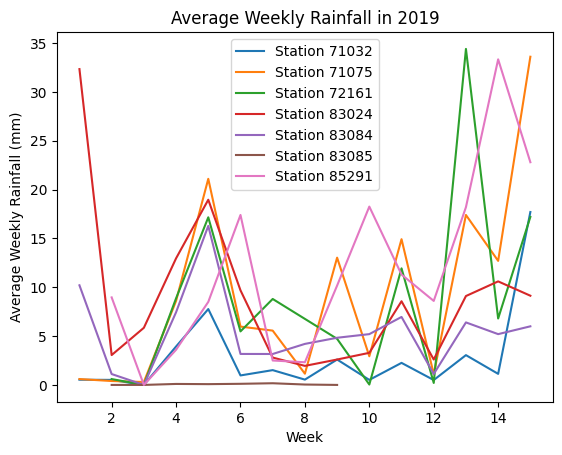

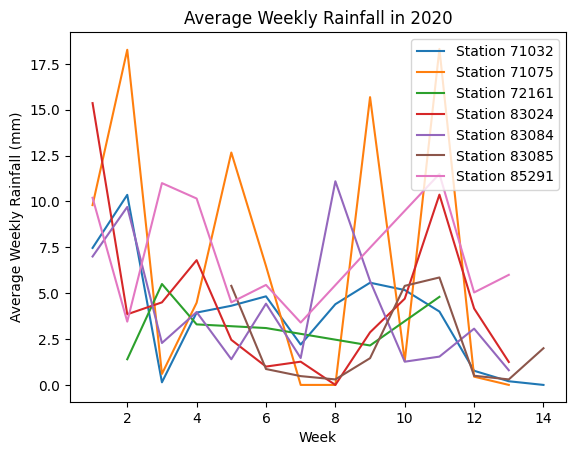

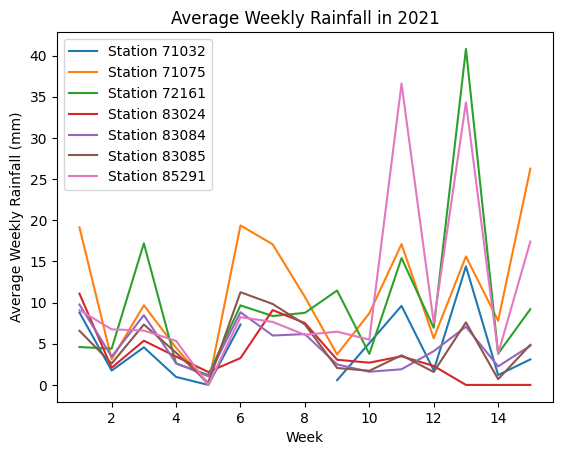

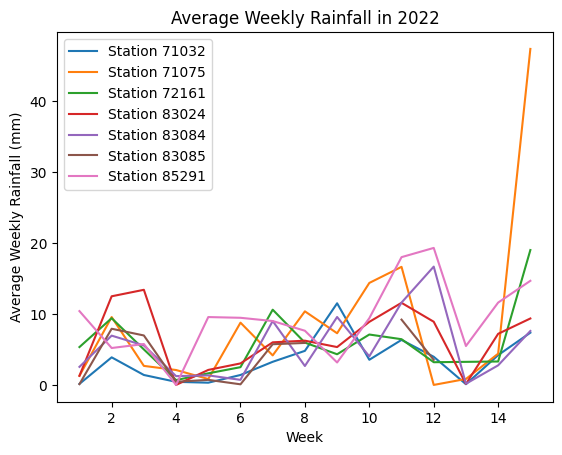

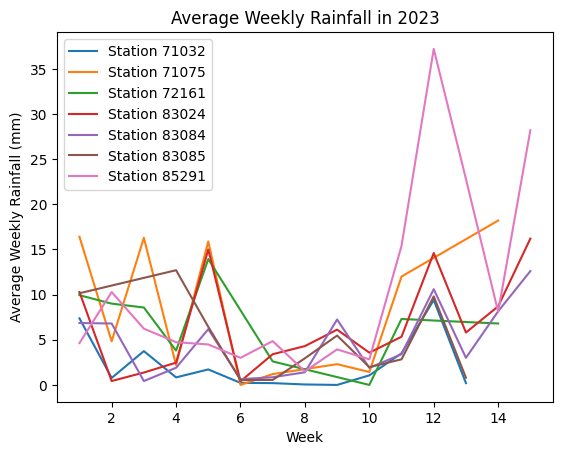

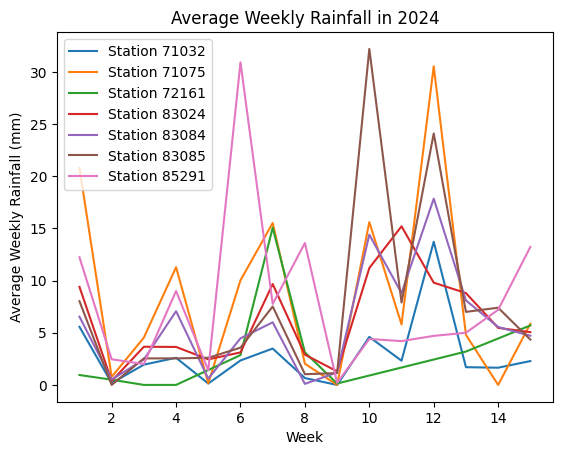

In [112]:
for year in weeklyWeather['Year'].unique():
    yearlyData = weeklyWeather[weeklyWeather['Year'] == year]
    for station in yearlyData['Bureau of Meteorology station number'].unique():
        stationData = yearlyData[yearlyData['Bureau of Meteorology station number'] == station]
        plt.plot(stationData['Week'], stationData['Rainfall amount (millimetres)'], label=f'Station {station}')
    plt.xlabel('Week')
    plt.ylabel('Average Weekly Rainfall (mm)')
    plt.title(f'Average Weekly Rainfall in {year}')
    plt.legend()
    plt.show()

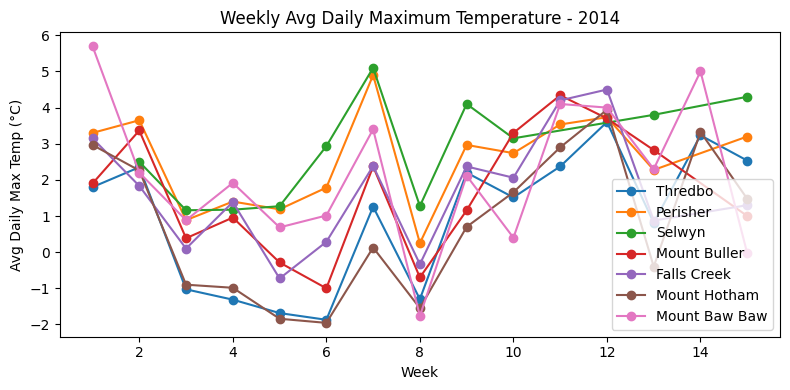

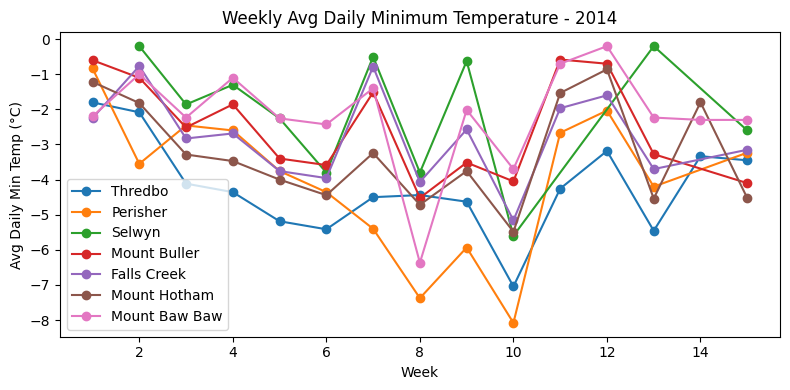

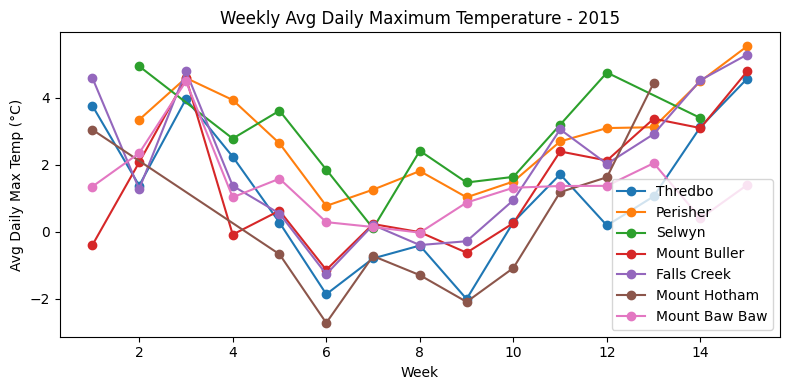

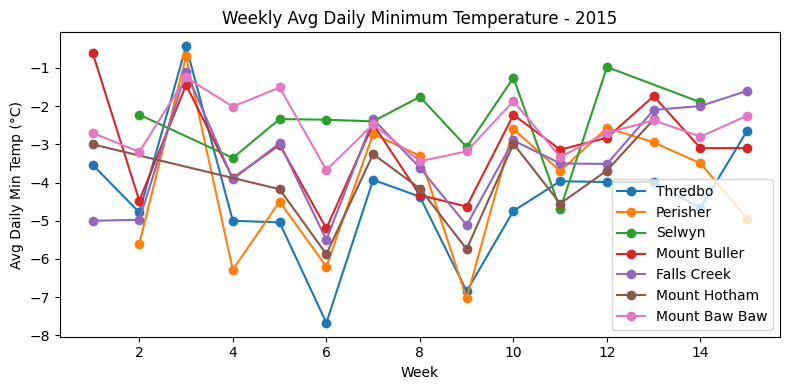

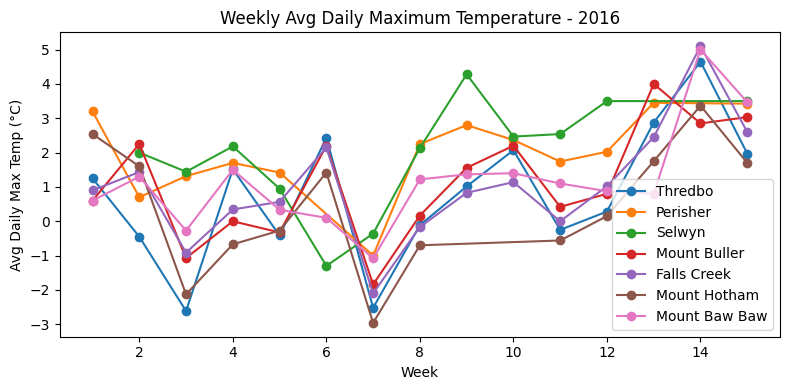

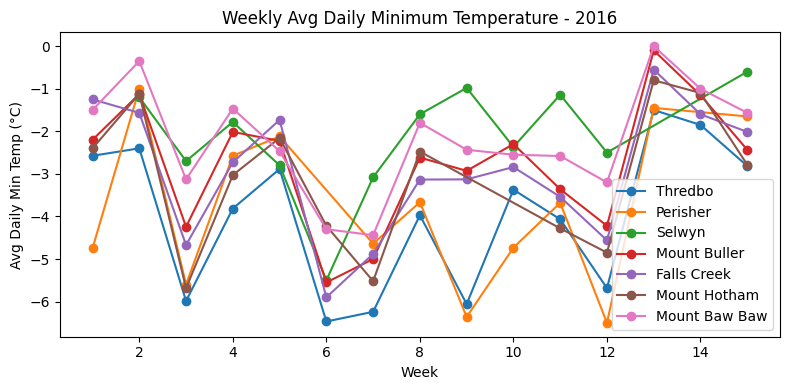

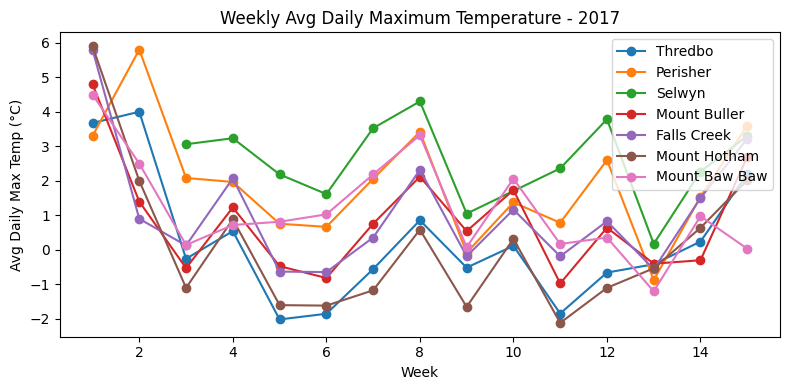

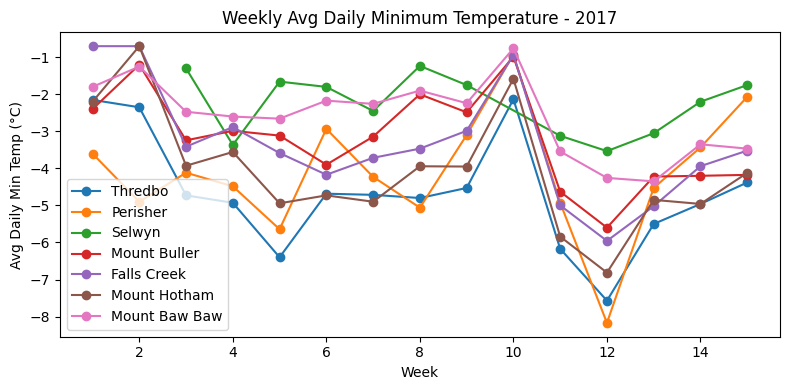

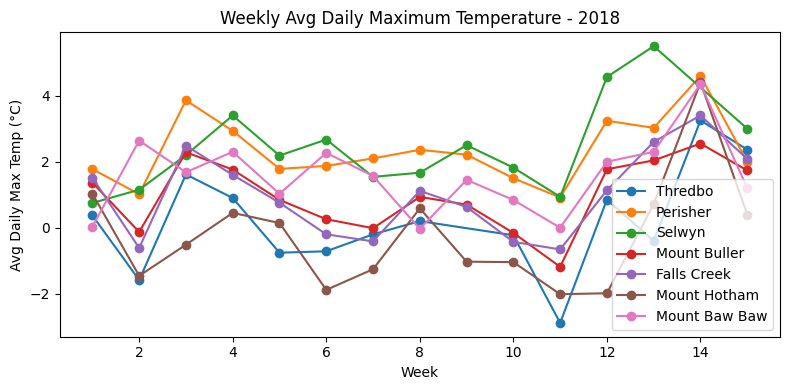

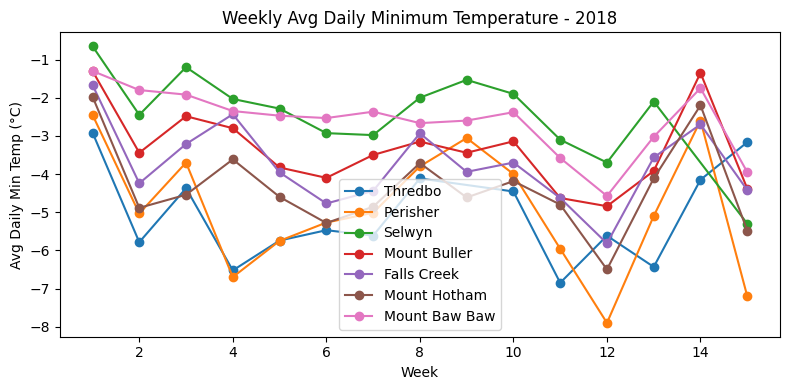

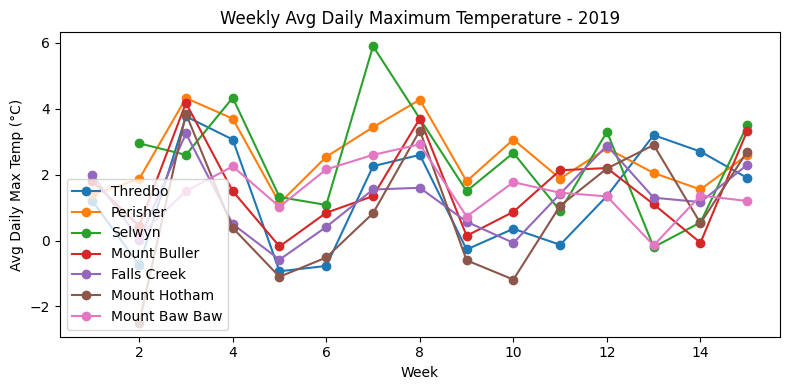

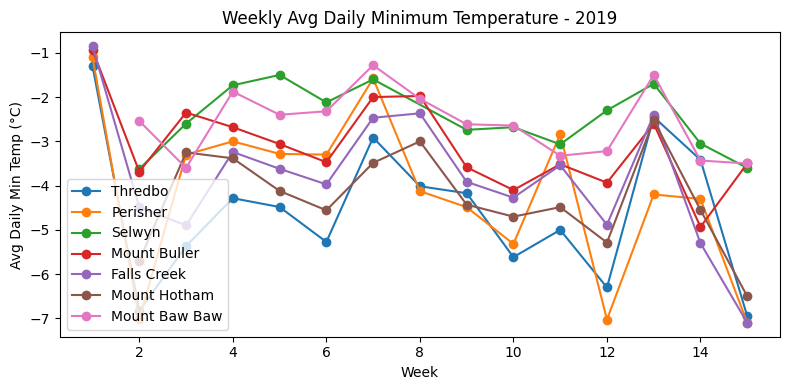

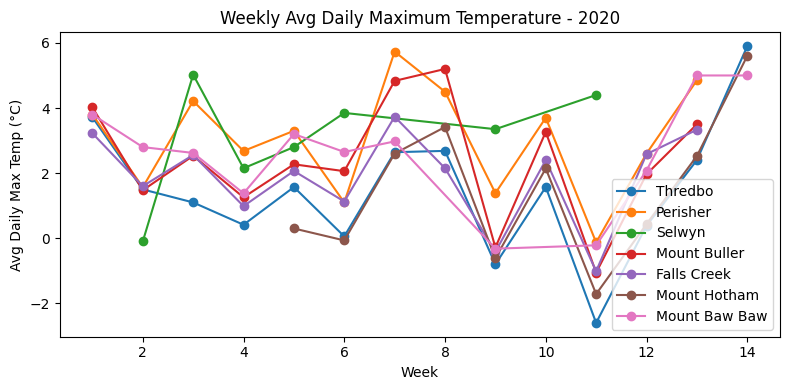

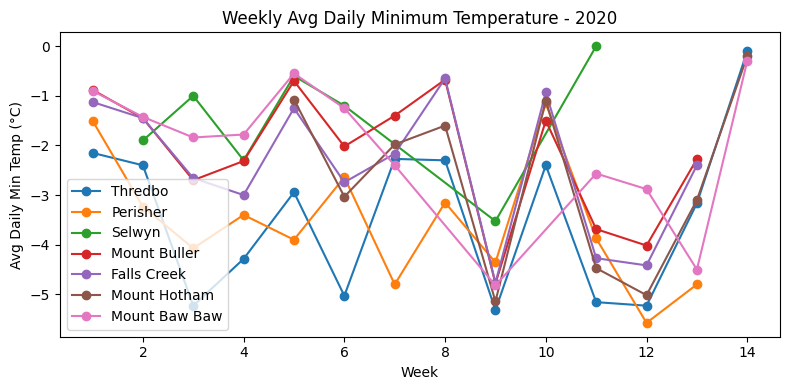

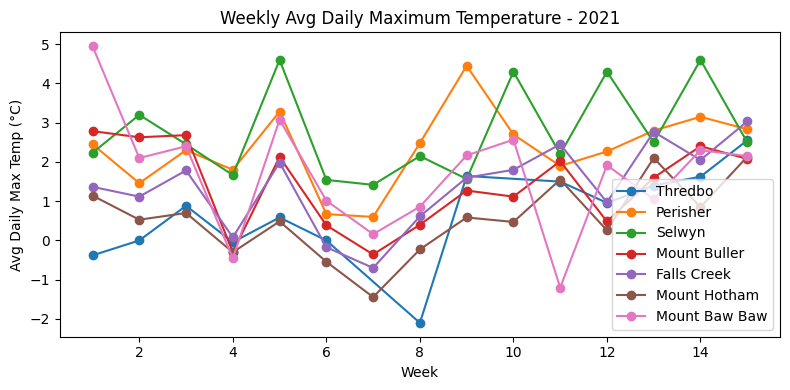

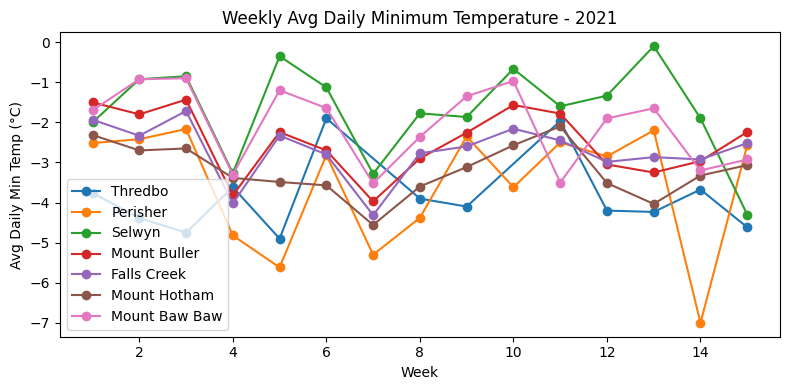

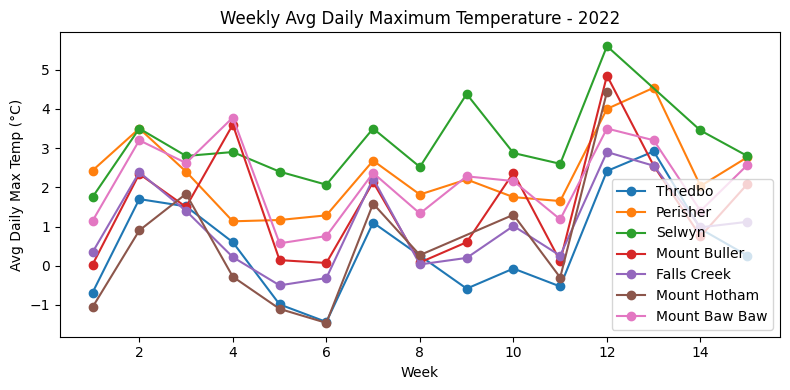

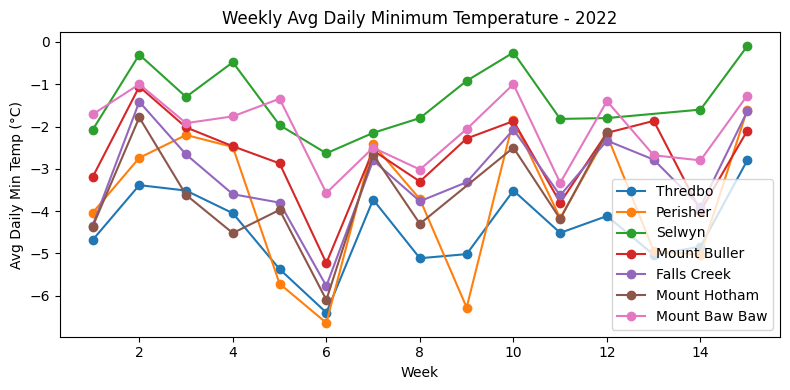

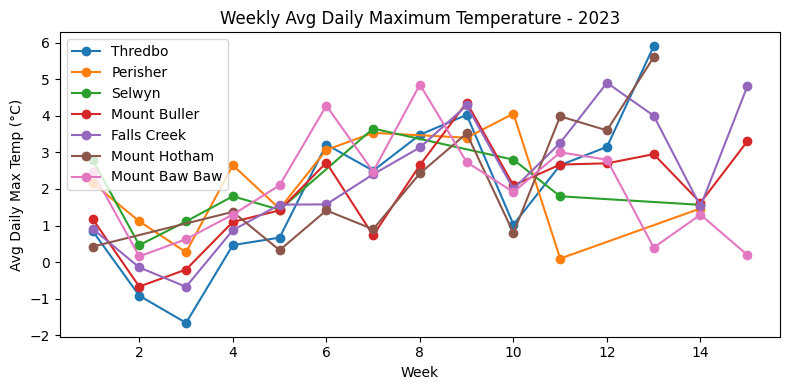

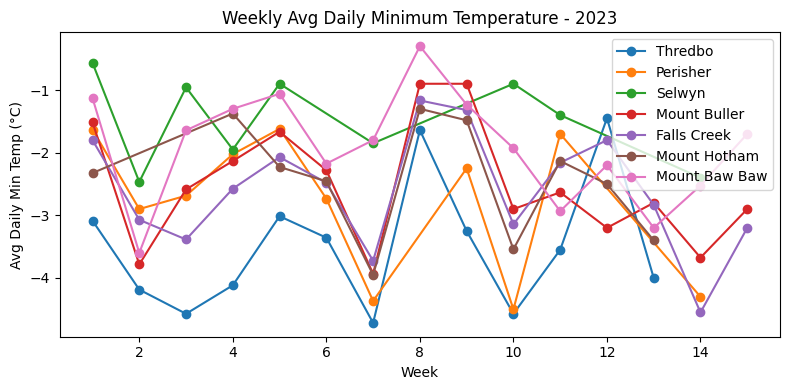

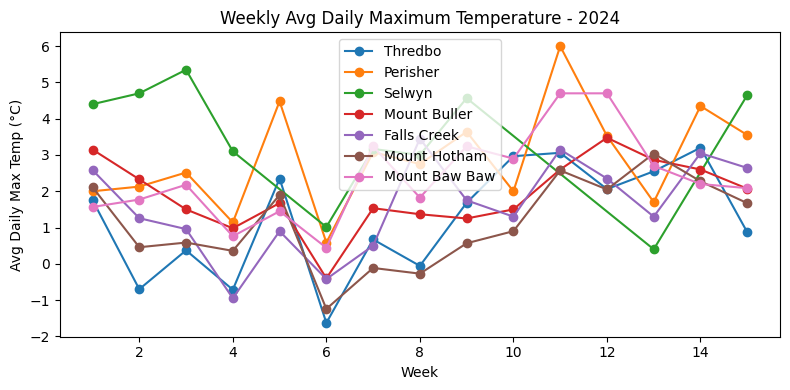

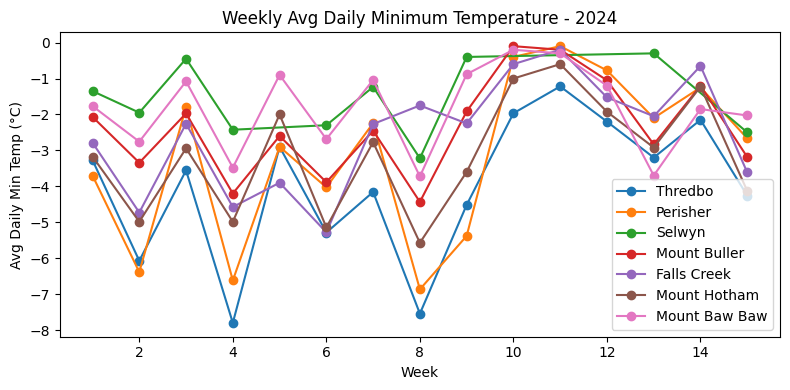

In [113]:
# ...existing code...
# Plot weekly average (or summed) Rainfall already above
# Replace the current max temperature plotting cell with the following:

# Weekly Max and Min Temperature plots (separate figures per year)
max_col = 'Maximum temperature (Degree C)'
min_col = 'Minimum temperature (Degree C)'  # adjust if actual column name differs
stationNumToName = {85291: "Mount Baw Baw", 83085:"Mount Hotham", 83024:"Mount Buller", 83084:"Falls Creek", 
                    72161:"Selwyn", 71075:"Perisher",71032:"Thredbo"}
for year in sorted(weeklyWeather['Year'].unique()):
    yearlyData = weeklyWeather[weeklyWeather['Year'] == year]

    # Figure 1: Weekly Max Temperature per station
    plt.figure(figsize=(8,4))
    for station in yearlyData['Bureau of Meteorology station number'].unique():
        stationData = yearlyData[yearlyData['Bureau of Meteorology station number'] == station]
        if max_col in stationData.columns:
            plt.plot(stationData['Week'], stationData[max_col], marker='o', label=f'{stationNumToName[int(station)]}')
    plt.xlabel('Week')
    plt.ylabel('Avg Daily Max Temp (°C)')
    plt.title(f'Weekly Avg Daily Maximum Temperature - {year}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Figure 2: Weekly Min Temperature per station
    plt.figure(figsize=(8,4))
    for station in yearlyData['Bureau of Meteorology station number'].unique():
        stationData = yearlyData[yearlyData['Bureau of Meteorology station number'] == station]
        if min_col in stationData.columns:
            plt.plot(stationData['Week'], stationData[min_col], marker='o', label=f'{stationNumToName[int(station)]}')
    plt.xlabel('Week')
    plt.ylabel('Avg Daily Min Temp (°C)')
    plt.title(f'Weekly Avg Daily Minimum Temperature - {year}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# If you instead want a single figure per year with both max & min averaged across all stations:
# agg = yearlyData.groupby('Week')[[max_col, min_col]].mean()
# plt.plot(agg.index, agg[max_col], label='Avg Max')
# plt.plot(agg.index, agg[min_col], label='Avg Min')
# ...existing code...